In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
from matmul import linear_estimates, logit_estimates, attend_estimates, fused_logit_softmax_dpr_attend_estimates
from norm import layer_norm_estimates
from pointwise import softmax_estimates, dropout_estimates, nonlinear_act_estimates
from time_projections import get_time_flops, get_time_mem, get_time_comm, get_topology, get_total_time

In [3]:
def compute_timings_and_stats(summary, system):
    ''' timings, any other df stats '''

    # which layers use tensor cores
    tensor_core_layers = ['fc1', 'fc2', 'qkv_proj', 'v_proj', 'logits', 'attend']
   
    # time for forward
    summary['t_comp_fwd'] = summary.apply(lambda x: get_time_flops(x["flops_fwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_fwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_fwd"], system=system), axis=1)
    # time for backward
    summary['t_comp_bwd'] = summary.apply(lambda x: get_time_flops(x["flops_bwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_bwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_bwd"], system=system), axis=1)
    
    # times
    summary['intensity'] = summary['t_comp_fwd'] / summary['t_mem_fwd']
    summary['t_fwd'] = summary.apply(lambda x: max(x['t_comp_fwd'], x['t_mem_fwd']), axis=1)
    summary['t_bwd'] = summary.apply(lambda x: max(x['t_comp_bwd'], x['t_mem_bwd']), axis=1)
    
    # time for communication
    use_empirical = False
    summary['comm_topology'] = summary.apply(lambda x: get_topology(x["comm_size"], system=system), axis=1)
    summary['t_comm_fwd'] = summary.apply(lambda x: get_time_comm(x["comm_fwd"],
                                                                  n_gpus=x["comm_size"],
                                                                  comm_type=x["comm_fwd_type"], 
                                                                  topology=x["comm_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    summary['t_comm_bwd'] = summary.apply(lambda x: get_time_comm(x["comm_bwd"],
                                                                  n_gpus=x["comm_size"],
                                                                  comm_type=x["comm_bwd_type"], 
                                                                  topology=x["comm_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    
    # total time
    summary['t_total_fwd'] = summary.apply(lambda x: get_total_time(x['t_fwd'], x['t_comm_fwd'], use_max=False), axis=1)
    summary['t_total_bwd'] = summary.apply(lambda x: get_total_time(x['t_bwd'], x['t_comm_bwd'], use_max=False), axis=1)
    
    # fraction
    summary['frac_t_comm_fwd'] = summary['t_comm_fwd'] / summary['t_total_fwd']
    summary['frac_t_comm_bwd'] = summary['t_comm_bwd'] / summary['t_total_bwd']

    return summary

In [4]:
#### nn modules ###
def MLP_estimates(b, l, e, f, depth, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, parallelism={'m1': 1, 'm2': 1}, system={}):
    """
    MLP layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim
                f: hidden dim
                element_size: in MB
                mask_element_size: in MB (for dropout)
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        forward pass: 
             X = XW + b
             (b,l,f) = (b,l,e) * (e,f) + (1,f)
             X = nonlinear(X)
             (b,l,f) = (b,l,f)
             X = dropout(X)
             (b,l,f) = (b,l,f) * (b,l,f) [random mask]
             X = linear(X)
             (b,l,e) = (b,l,f) * (f,e) + (1,e)
             X = dropout(X)
             (b,l,e) = (b,l,e) * (b,l,e) [random mask]
            
        backward pass:
             chain rule
             
    parallelism:
            X = XW + b
            (b,l/m2,f/m1) = (b,l/m2,e/m1) * (e/m2,f/m1) + (1,f/m1)
            X = nonlinear(X)
            (b,l/m2,f/m1) = (b,l/m2,f/m1)
            X = dropout(X)
            (b,l/m2,f/m1) = (b,l/m2,f/m1) * (b,l/m2,f/m1) [random mask]
            X = linear(X)
            (b,l/m2,e/m1) = (b,l/m2,f/m1) * (f/m2,e/m1) + (1,e/m1)
            X = dropout(X)
            (b,l/m2,e/m1) = (b,l/m2,e/m1) * (b,l/m2,e/m1) [random mask]
            
    comments: 
    """
    
    summary = []
    
    m1 = parallelism['m1']
    m2 = parallelism['m2'] 
    
    m1_parallel = (m1 > 1)
    m2_parallel = (m2 > 1)
    
    
    total_time = 0
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    stats = linear_estimates_summa(b, l, e, f, element_size=element_size, has_bias=True, flops_units=flops_units, parallelism={'dim1': m1, 'dim2': m2})
    stats["layer"] = "fc1"   
    # sync/comm layers
    stats["comm_fwd"] = [m1_parallel * (b * l // m2 * e) * element_size,
                         m2_parallel * (e * f // m1) * element_size] # both inputs are broadcasted in diff dims
    stats["comm_fwd_type"] = ["broadcast", "broadcast"]
    stats["comm_size"] = [m1, m2]
    
    stats["comm_bwd"] = [m2_parallel * (e * f // m1) * element_size, # dl/dx = dl/dy * wT
                         m1_parallel * (b * l // m2 * e) * element_size, # reduce result
                         m1_parallel * (b * l // m2 * e) * element_size, # dl/dw = xT * dl/dy
                         m2_parallel * (e * f // m1) * element_size, # reduce temp result
                         m2_parallel * (f // m1) * element_size] # allreduce bias
    stats["comm_bwd_type"] = ["broadcast", "reduce", "broadcast", "reduce", "allreduce"]
    stats["comm_size"] = [m2, m1, m1, m2, m2]
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = nonlinear_act_estimates(b, l // m2, f // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "act"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, f // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr1"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates_summa(b, l, f, e, element_size=element_size, has_bias=True, flops_units=flops_units, parallelism={'dim1': m1, 'dim2': m2})
    stats["layer"] = "fc2"
    # sync/comm layers
    stats["comm_fwd"] = [m1_parallel * (b * l // m2 * f) * element_size,
                         m2_parallel * (f * e // m1) * element_size] # both inputs are broadcasted in diff dims
    stats["comm_fwd_type"] = ["broadcast", "broadcast"]
    stats["comm_size"] = [m1, m2]
    
    stats["comm_bwd"] = [m2_parallel * (f * e // m1) * element_size, # dl/dx = dl/dy * wT
                         m1_parallel * (b * l // m2 * f) * element_size, # reduce result
                         m1_parallel * (b * l // m2 * f) * element_size, # dl/dw = xT * dl/dy
                         m2_parallel * (f * e // m1) * element_size, # reduce temp result
                         m2_parallel * (e // m1) * element_size] # allreduce bias
    stats["comm_bwd_type"] = ["broadcast", "reduce", "broadcast", "reduce", "allreduce"]
    stats["comm_size"] = [m2, m1, m1, m2, m2]
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m2, e // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr2"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)
    
    return summary
        

In [5]:
def self_attention_estimates(b, l, e, h, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, flash_attention=True, parallelism={'m1': 1, 'm2': 1}, system={}):
    """
    dropout layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim/hidden dim
                h: number of attention heads
                element_size: in MB
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        define: q = e/h
        forward pass: 
             X = norm(X)
             Q = XW, K = XW, V = XW
             (b,l,h,q,3) = (b,l,e) * (e,3hq)
             A = QK'/sqrt(q)
             (b,h,l,l) = (b,h,l,q) * (b,h,q,l)
             A = softmax(A)
             (b,h,l,l) = (b,h,l,l)
             A = dpr(A)
             Y = AV
             (b,h,l,q) = (b,h,l,l) * (b,h,l,q)
             Y = VW
             (b,l,e) = (b,l,hq) * (hq,e)
             Y = dpr(Y)
             (b,l,e) = (b,l,e)
             Y = norm(Y)
             (b,l,e) = (b,l,e)
             
        backward pass:
             chain rule
             
        parallelism: (TODO: not done, working on it: Sh) 
             X = norm(X)
             (b,l/m2,e/m1) = (b,l/m2,e/m1)
             Q = XW, K = XW, V = XW
             (b,l/m2,h/m1,q,3) = (b,l/m2,e/m1) * (e/m2,3hq/m1)
             A = QK'/sqrt(q)
             (b,h/m1,l,l) = (b,h/m1,l,q) * (b,h/m1,q,l)
             A = softmax(A)
             (b,h/m1,l,l) = (b,h/m1,l,l)
             A = dpr(A)
             (b,h/m1,l,l) = (b,h/m1,l,l)
             Y = AV
             (b,h/m,l,q) = (b,h/m,l,l) * (b,h/m,l,q)
             Y = VW
             (b,l,e) = (b,l,hq/m) * (hq/m,e)
             Y = dpr(Y)
             (b,l,e) = (b,l,e)
             Y = norm(Y)
             (b,l,e) = (b,l,e)
            
    
    comments: 
    """
    summary = []
    
    q = e // h
    
    m1 = parallelism['m1']
    m2 = parallelism['m2'] 
    
    m1_parallel = (m1 > 1)
    m2_parallel = (m2 > 1)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    ### not done TODO: working on it: Sh
    stats = layer_norm_estimates(b, l // m2, e // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_1"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l, e, (3*e) // m1, element_size=element_size, has_bias=False, flops_units=flops_units)
    stats["layer"] = "qkv_proj"
    # sync/comm layers: no fwd coms here
    stats["comm_bwd"] = m1_parallel * (b * l * e) * element_size # reduce scatter before going to ln: TODO check?
    stats["comm_bwd_type"] = "reducescatter"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    if flash_attention:
        stats = fused_logit_softmax_dpr_attend_estimates(b, l, q, h // m1, element_size=element_size, flops_units=flops_units)
        stats["layer"] = "fused_la"
        summary.append(stats)
    else:
        stats = logit_estimates(b, l, q, h // m1, element_size=element_size, flops_units=flops_units)
        stats["layer"] = "logits"
        summary.append(stats)
        ######################################################################################################################################################
        ######################################################################################################################################################

        stats = softmax_estimates(b, l, h // m1, element_size=element_size, flops_units=flops_units)
        stats["layer"] = "softmax"
        summary.append(stats)

        ######################################################################################################################################################
        ######################################################################################################################################################

        stats = dropout_estimates(b, l, (l*h) // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
        stats["layer"] = "dropout_softmax"
        summary.append(stats)

        ######################################################################################################################################################
        ######################################################################################################################################################

        stats = attend_estimates(b, l, q, h // m1, element_size=element_size, flops_units=flops_units)
        stats["layer"] = "attend"
        summary.append(stats)    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l, (h*q) // m1, e, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "v_proj"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # fwd comms for partial sums of b,l,e
    stats["comm_fwd_type"] = "reducescatter"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m1, e, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dropout"
    # sync/comm layers
    stats["comm_bwd"] = m1_parallel * (b * l * e) * element_size
    stats["comm_bwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = layer_norm_estimates(b, l // m1, e, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_2"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)

    
    return summary

In [6]:
### model
pd.options.display.max_columns = None
pd.options.display.max_rows = None
b = 1
patch = 16
ih = 720
iw = 1440 
l = 2048 #ih // patch * iw // patch
e = 12288
f = 4 * e
h = 96
depth = 96
fp32_sz = 4E-9
fp16_sz = 2E-9
int_sz = 1E-9
flops_units = 1E-12 # teraflops

print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

### model parallelism
parallelism = {'m1': 4,
               'm2': 1}
### system configs
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 300,
          'ib_bandwidth': 100,
          'nvlink_size': 4}
print("parallelization: m1 = {}, m2 = {}".format(parallelism['m1'], parallelism['m2']))

# MLP
df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                       parallelism=parallelism, system=system)
cols = df_mlp.columns.tolist()
cols.remove('layer')
cols = ['layer'] + cols

# self attention
df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                                 flash_attention=True, parallelism=parallelism, system=system)

# sum these columns (mem in buffer: activation buffers, weights, weights_grads, total flops, timings)
layer_track_cols = ['activation_buffer', 'weights_mem', 
                    'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                    't_total_fwd', 't_total_bwd', 't_comm_fwd', 't_comm_bwd']

print('\n************** MLP layer estimates **************\n')
display(df_mlp[cols])
display(df_mlp[layer_track_cols].sum() * depth)
t_f = df_mlp['t_total_fwd'].sum()
t_c = df_mlp['t_comm_fwd'].sum()
print('time spend in comms = {}'.format(t_c / t_f))

print('\n************** SA layer estimates **************\n')
display(df_sa[cols])
display(df_sa[layer_track_cols].sum() * depth)
t_f = df_sa['t_total_fwd'].sum()
t_c = df_sa['t_comm_fwd'].sum()
print('time spend in comms = {}'.format(t_c / t_f))

print('\n************** Training estimates **************\n')
t_itr = (df_mlp['t_total_fwd'].sum() + df_mlp['t_total_bwd'].sum() + df_sa['t_total_fwd'].sum() + df_sa['t_total_bwd'].sum()) * depth
print('time for 1 itr = {}'.format(t_itr))

model: batch size = 1, seq length = 2048, embed = 12288, attention heads = 96, depth = 96
parallelization: m1 = 4, m2 = 1

************** MLP layer estimates **************



,layer,flops_fwd,activation_in_mem,activation_in_other_mem,activation_out_mem,activation_buffer,weights_mem,total_mem_fwd,flops_bwd,activation_grad_mem,weights_grad_mem,total_mem_bwd,comm_bwd,comm_bwd_type,comm_size,comm_fwd,comm_fwd_type,t_comp_fwd,t_mem_fwd,t_comp_bwd,t_mem_bwd,intensity,t_fwd,t_bwd,comm_topology,t_comm_fwd,t_comm_bwd,t_total_fwd,t_total_bwd,frac_t_comm_fwd,frac_t_comm_bwd
0,fc1,0.618475,0.050332,0.000000,0.050332,0.050332,0.302014,0.402678,1.236800,0.100663,0.302014,0.755024,0.050332,reducescatter,4.0,NaN,NaN,1.982293,0.258957,3.964101,0.485546,7.654917,1.982293,3.964101,nvlink,0.000000,0.167772,1.982293,4.131873,0.000000,0.040604
1,act,0.000025,0.050332,0.000000,0.050332,0.050332,0.000000,0.100663,0.000025,0.100663,0.000000,0.150995,NaN,NaN,NaN,NaN,NaN,0.000323,0.064735,0.000323,0.097103,0.004984,0.064735,0.097103,None,0.000000,0.000000,0.064735,0.097103,0.000000,0.000000
2,dpr1,0.000025,0.050332,0.025166,0.050332,0.025166,0.000000,0.125829,0.000025,0.100663,0.000000,0.125829,NaN,NaN,NaN,NaN,NaN,0.000323,0.080919,0.000323,0.080919,0.003987,0.080919,0.080919,None,0.000000,0.000000,0.080919,0.080919,0.000000,0.000000
3,fc2,0.618475,0.050332,0.000000,0.050332,0.050332,0.302014,0.402678,1.236800,0.100663,0.302014,0.755024,NaN,NaN,4.0,0.050332,reducescatter,1.982293,0.258957,3.964101,0.485546,7.654917,1.982293,3.964101,nvlink,0.167772,0.000000,2.150065,3.964101,0.078031,0.000000
4,dpr2,0.000006,0.012583,0.006291,0.012583,0.006291,0.000000,0.031457,0.000006,0.025166,0.000000,0.031457,0.050332,allgather,4.0,NaN,NaN,0.000081,0.020230,0.000081,0.020230,0.003987,0.020230,0.020230,nvlink,0.000000,0.167772,0.020230,0.188002,0.000000,0.892396


activation_buffer     17.515414
weights_mem           57.986777
weights_grad_mem      57.986777
flops_fwd            118.752692
flops_bwd            237.470956
t_total_fwd          412.631175
t_total_bwd          812.351853
t_comm_fwd            16.106127
t_comm_bwd            32.212255
dtype: float64

time spend in comms = 0.03903274483320573

************** SA layer estimates **************



,layer,flops_fwd,activation_in_mem,activation_in_other_mem,activation_out_mem,activation_buffer,weights_mem,total_mem_fwd,flops_bwd,activation_grad_mem,weights_grad_mem,total_mem_bwd,comm_bwd,comm_bwd_type,comm_size,comm_fwd,comm_fwd_type,t_comp_fwd,t_mem_fwd,t_comp_bwd,t_mem_bwd,intensity,t_fwd,t_bwd,comm_topology,t_comm_fwd,t_comm_bwd,t_total_fwd,t_total_bwd,frac_t_comm_fwd,frac_t_comm_bwd
0,layer_norm_1,0.000057,0.012583,0.000002,0.012583,0.012583,0.000049,0.025217,0.000082,0.025166,0.000049,0.037798,NaN,NaN,4.0,0.050332,allgather,0.000726,0.016217,0.001049,0.024307,0.044765,0.016217,0.024307,nvlink,0.167772,0.000000,0.183989,0.024307,0.911860,0.000000
1,qkv_proj,0.463838,0.050332,0.000000,0.037749,0.050332,0.226492,0.314573,0.927575,0.088080,0.226492,0.591397,0.050332,reducescatter,4.0,NaN,NaN,1.486659,0.202298,2.972995,0.380320,7.348870,1.486659,2.972995,nvlink,0.000000,0.167772,1.486659,3.140767,0.000000,0.053418
2,fused_la,0.051835,0.012583,0.025264,0.012583,0.037945,0.000000,0.050430,0.129535,0.050332,0.000000,0.088277,NaN,NaN,NaN,NaN,NaN,0.664555,0.032431,1.660701,0.056770,20.491441,0.664555,1.660701,None,0.000000,0.000000,0.664555,1.660701,0.000000,0.000000
3,v_proj,0.154619,0.012583,0.000000,0.050332,0.012583,0.075522,0.138437,0.309219,0.062915,0.075522,0.226542,NaN,NaN,4.0,0.050332,reducescatter,0.495573,0.089027,0.991086,0.145686,5.566564,0.495573,0.991086,nvlink,0.167772,0.000000,0.663345,0.991086,0.252918,0.000000
4,dropout,0.000006,0.012583,0.006291,0.012583,0.006291,0.000000,0.031457,0.000006,0.025166,0.000000,0.031457,0.050332,allgather,4.0,NaN,NaN,0.000081,0.020230,0.000081,0.020230,0.003987,0.020230,0.020230,nvlink,0.000000,0.167772,0.020230,0.188002,0.000000,0.892396
5,layer_norm_2,0.000057,0.012583,0.000002,0.012583,0.012583,0.000049,0.025217,0.000082,0.025166,0.000049,0.037798,NaN,NaN,4.0,0.050332,allgather,0.000726,0.016217,0.001049,0.024307,0.044765,0.016217,0.024307,nvlink,0.167772,0.000000,0.183989,0.024307,0.911860,0.000000


activation_buffer     12.702450
weights_mem           29.002826
weights_grad_mem      29.002826
flops_fwd             64.359476
flops_bwd            131.183794
t_total_fwd          307.465574
t_total_bwd          578.800411
t_comm_fwd            48.318382
t_comm_bwd            32.212255
dtype: float64

time spend in comms = 0.15715054376770995

************** Training estimates **************

time for 1 itr = 2111.2490119776876


In [7]:
def plot(n_gpus, parallelism, system, axs, lgnd=['MLP', 'SA'], lgnd_tot=['nvlink1'], lfmt="-"):
    t_frac_mlp = []
    t_frac_sa = []

    t_mlp_c = []
    t_sa_c = []

    t_mlp_comm = []
    t_sa_comm = []
    
    t_itr = []

    for n in n_gpus:
        parallelism['m1'] = n
        parallelism['m2'] = 1

        df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                               parallelism=parallelism, system=system)
        df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                                         flash_attention=True, parallelism=parallelism, system=system)
        t_f = df_mlp['t_total_fwd'].sum()* depth
        t_c = df_mlp['t_comm_fwd'].sum()* depth
        t_mlp_c.append(t_f)
        t_mlp_comm.append(t_c)
        t_frac_mlp.append(t_c / t_f)

        t_f = df_sa['t_total_fwd'].sum()* depth
        t_c = df_sa['t_comm_fwd'].sum()* depth
        t_sa_c.append(t_f)
        t_sa_comm.append(t_c)
        t_frac_sa.append(t_c / t_f)
        
        t_itr.append((df_mlp['t_total_fwd'].sum() + df_mlp['t_total_bwd'].sum() + df_sa['t_total_fwd'].sum() + df_sa['t_total_bwd'].sum()) * depth)


    ax = axs[0]
    ax.plot(n_gpus, t_frac_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_frac_sa, lfmt, linewidth=2, c=c2)
    # ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Fraction of time in comms', fontsize=fsz)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=fsz-4)
    ax.legend(lgnd, fontsize=fsz-4)


    ax = axs[1]
    ax.plot(n_gpus, t_mlp_c, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa_c, lfmt, linewidth=2, c=c2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total fwd time', fontsize=fsz)
    
    ax.legend(lgnd, fontsize=fsz-4)
    
    ax = axs[2]
    ax.plot(n_gpus, t_itr, lfmt, linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log', base=2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    # ax.set_yticks(list(np.arange(0,2000,100)))
    # ax.set_yticklabels(list(np.arange(0,2000,100)), fontsize=fsz-4)
    ax.legend(lgnd_tot, fontsize=fsz-4)
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%d"))

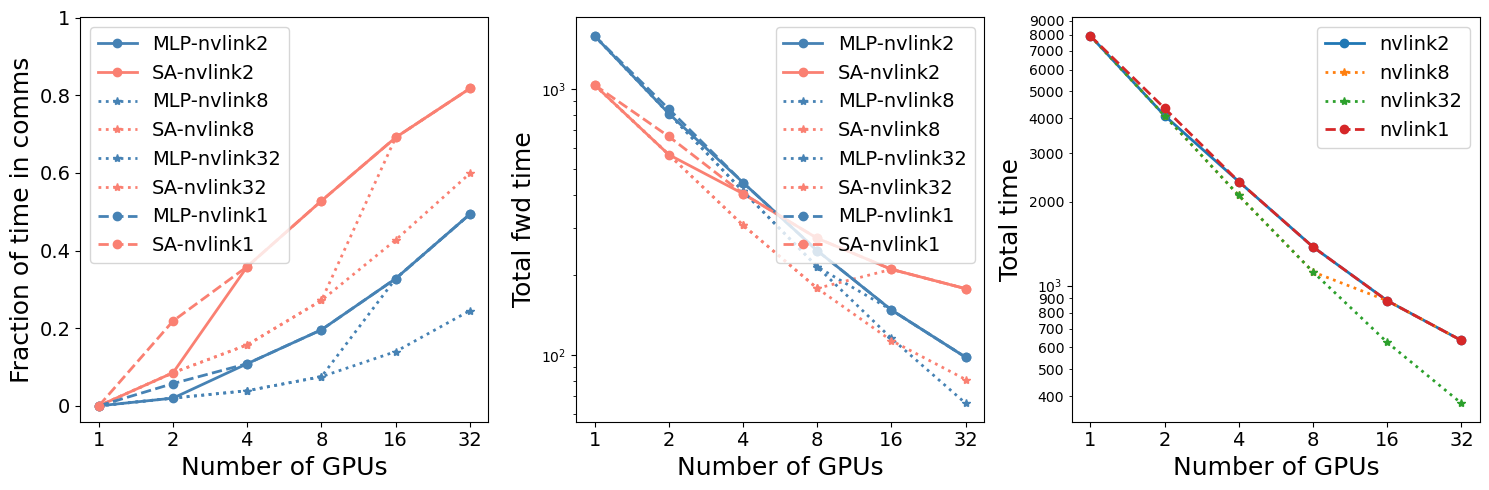

In [11]:
# Sweeps
### model parallelism
n_gpus = [1, 2, 4, 8, 16, 32]
parallelism = {'m1': 1,
               'm2': 1}
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 300,
          'ib_bandwidth': 100,
          'nvlink_size': 8}

fig, axs = plt.subplots(1,3,figsize=(15,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 2
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot = ["nvlink{}".format(nvs)]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o-")
nvs = 8
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
nvs = 32
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
lgnd_tot += ["nvlink{}".format(nvs)]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="*:")
system['nvlink_size'] = 1
lgnd += ["MLP-nvlink1", "SA-nvlink1"]
lgnd_tot += ["nvlink1"]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lgnd_tot=lgnd_tot, lfmt="o--")